<a href="https://colab.research.google.com/github/Saket03-P/Ethereum-Transactions-Fraud-Detection/blob/main/Models/MP_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethereum Fraud Detection using XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/stable/)

In [ ]:
# Import following libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Mount colab to google drive.
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Retrieve the csv file from google drive.

path= '/content/gdrive/MyDrive/Cost Sensitive Approach for Ethereum Transactions Fraud Detection using Machine Learning/increased_transaction_dataset.csv'
dft= pd.read_csv(path)
dft.sample(5)

,Unnamed: 0,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
18727,18727,Non - Fraud,466.01,0.000000,13936.697680,9,0,0,113.484531,61.673433,5.689906,915.801375,-450.902941,0.000000e+00,4.604528e+06,0.0,1.0,0.0,5,3
5985,5985,Non - Fraud,0.00,2752.640000,319306.250000,0,116,1,1.005229,0.594147,0.000000,0.000000,68.921092,6.751037e+00,0.000000e+00,0.0,0.0,4.0,185,119
661,661,Fraud,0.00,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.337000e+01,0.000000e+00,0.0,0.0,1.0,1,74
3146,3146,Fraud,0.00,1001.760000,47115.170000,1,8,0,9.000000,2.004672,16.036330,16.036330,0.001050,1.000000e-12,0.000000e+00,0.0,0.0,1.0,-1,-1
10616,10616,Fraud,28.24,408.643237,3706.533586,0,5,0,23.901216,9.804059,0.000000,114.416949,269.218577,3.752934e+06,1.974439e+06,0.0,0.0,1.0,-1,1


In [ ]:
# Separate target column from the rest of the dataset.

X= dft[['Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'total Ether sent',
       'total ether balance', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec token name',
       ' ERC20 most sent token type', ' ERC20_most_rec_token_type']]

y= dft[['FLAG']]

In [ ]:
# Change to Numeric Columns for Cost Sensitive Learning.

y= y.replace('Fraud', 1)
y= y.replace('Non - Fraud', 0)

y.value_counts()

FLAG
0       15299
1        4383
dtype: int64

In [ ]:
balancing_factor= y.value_counts()[0] // y.value_counts()[1]
print(balancing_factor)

3


In [ ]:
%pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Make use of the same parameter values, they seem to ensure the best results.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

**XGBoost without Cost Sensitive Learning**

In [ ]:
import xgboost as xgb

xg1= xgb.XGBClassifier()
xg1.fit(x_train, y_train)
y_pred1= xg1.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4559
           1       0.99      0.97      0.98      1346

    accuracy                           0.99      5905
   macro avg       0.99      0.98      0.99      5905
weighted avg       0.99      0.99      0.99      5905



In [ ]:
from sklearn import metrics

cm1= metrics.confusion_matrix(y_test, y_pred1)
cm1

array([[4540,   19],
       [  40, 1306]])

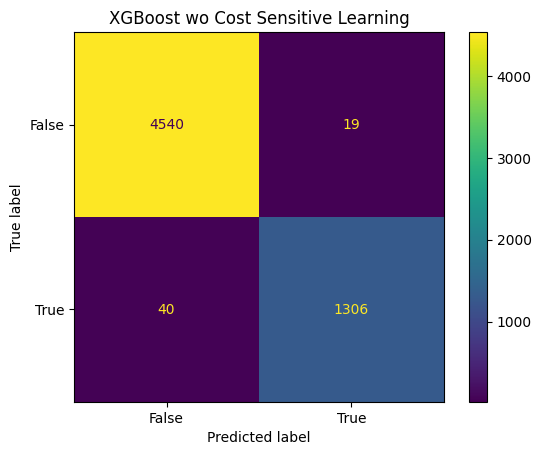

In [ ]:
display_cm1 = metrics.ConfusionMatrixDisplay(confusion_matrix= cm1, display_labels= [False, True])

display_cm1.plot()
plt.title('XGBoost wo Cost Sensitive Learning')

In [ ]:
from sklearn.metrics import accuracy_score

print('XGBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred1)))

XGBoost Model accuracy score: 0.9900


In [ ]:
y_pred_train1= xg1.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train1)))

Training-set accuracy score: 1.0000


**XGBoost with Cost Sensitive Learning of 3**

In [ ]:
xg2= xgb.XGBClassifier(scale_pos_weight= balancing_factor)
xg2.fit(x_train, y_train)
y_pred2= xg2.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4559
           1       0.98      0.97      0.98      1346

    accuracy                           0.99      5905
   macro avg       0.99      0.99      0.99      5905
weighted avg       0.99      0.99      0.99      5905



In [ ]:
cm2= metrics.confusion_matrix(y_test, y_pred2)
cm2

array([[4538,   21],
       [  34, 1312]])

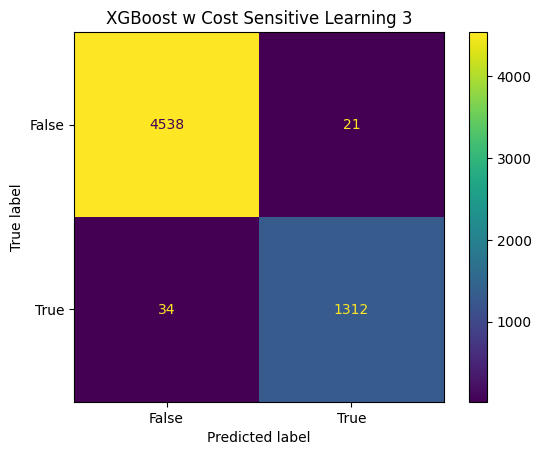

In [ ]:
display_cm2= metrics.ConfusionMatrixDisplay(confusion_matrix= cm2, display_labels= [False, True])

display_cm2.plot()
plt.title('XGBoost w Cost Sensitive Learning 3')